In [157]:
import pandas as pd
import rdkit.Chem as Chem
import rdkit.Chem.Scaffolds.MurckoScaffold as MurckoScaffold

In [158]:
# get murcko scaffolds of the D2 training set

df = pd.read_parquet('../data/d2_ECFP_100nM.parquet')
mols = df['smiles'].apply(lambda x: Chem.MolFromSmiles(x))
mols_scaffolds = [MurckoScaffold.GetScaffoldForMol(mol) for mol in mols]

# calculate morgan fingerprints of the D2 training set scaffolds

from rdkit.Chem import AllChem
import numpy as np

fps_train = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=512) for mol in mols_scaffolds]

In [201]:
# read the predictions

df = pd.read_csv('../results/latent_vectors_20241217_173316/preds_20241218-131752/predictions.csv')
df.head()

,idx,smiles,largest_ring,num_rings,qed,mol_wt,num_HBA,num_HBD,logP,num_rotatable_bonds,tpsa,bridgehead_atoms,spiro_atoms,novelty_score,closest_in_train
0,53,Nc1cc(C(=O)O)ccc1C(=O)c1ccccc1C(=O)O,6,2,0.582924,285.063722,4,3,1.8962,4,117.69,0,0,0.692308,Cc1ccc(S(=O)(=O)Nc2ccc3c(c2)CCN(Cc2cc[nH]n2)CC...
1,120,Oc1c(OCCc2cccc(F)c2)ncnn1,6,2,0.865551,235.075705,5,1,1.3378,4,68.13,0,0,0.586957,Cc1ccc(N2CCN(CC3CC3c3ccccc3)CC2)c(C)c1
2,132,CCn1c(SC(C)=O)nc2nc(OC)c(OC)c(OC)c21,6,2,0.782740,311.093977,8,0,2.1156,5,75.47,0,0,0.723077,CC(NC(=O)CCCCCN1CCN(c2ccccc2-c2ccccc2)CC1)c1cc...
3,162,CC(C)(C)c1cccc(NC(=O)Nc2ccc(OC)cc2)c1,6,2,0.867157,298.168128,2,2,4.6367,3,50.36,0,0,0.645161,CC(C)NCC(O)c1ccc(O)c(O)c1
4,216,O=C(O)CCOc1cc(I)ccc1Oc1cc2ccc(I)cc2c(O)n1,6,3,0.410099,576.888319,5,2,4.7954,6,88.88,0,0,0.756410,O=C(NC1CCC(CCN2CCC(c3coc4ccccc34)CC2)CC1)C(O)C...


In [202]:
# get mols of the predictions and the closest molecule in the training set

mols_preds = df['smiles'].apply(lambda x: Chem.MolFromSmiles(x))
mols_train = df['closest_in_train'].apply(lambda x: Chem.MolFromSmiles(x))

# get Murcko scaffolds of the molecules

mols_preds_scaffolds = [MurckoScaffold.GetScaffoldForMol(mol) for mol in mols_preds]
mols_train_scaffolds = [MurckoScaffold.GetScaffoldForMol(mol) for mol in mols_train]

# calculate morgan fingerprints of the scaffolds

fps_preds = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=512) for mol in mols_preds_scaffolds]

In [203]:
# calculate Tanimoto similarity between the predictions and the training set

from rdkit import DataStructs

idxs = []
scores = []
for i, fp_pred in enumerate(fps_preds):
    similarities = [DataStructs.TanimotoSimilarity(fp_pred, fp) for fp in fps_train]
    idx = np.argmax(similarities)
    idxs.append(idx)
    scores.append(similarities[idx])
novelty_score = 1 - np.array(scores)
closest_scaffolds = [mols_scaffolds[idx] for idx in idxs]

In [204]:
# plot histogram of novelty scores

scaffolds_df = pd.DataFrame({'scaffold_pred': mols_preds_scaffolds, 'scaffold_train': closest_scaffolds, 'novelty_score': novelty_score})
scaffolds_df.head()

,scaffold_pred,scaffold_train,novelty_score
0,<rdkit.Chem.rdchem.Mol object at 0x7bce7b5fe500>,<rdkit.Chem.rdchem.Mol object at 0x7bce7a9f6880>,0.535714
1,<rdkit.Chem.rdchem.Mol object at 0x7bce7b5fe490>,<rdkit.Chem.rdchem.Mol object at 0x7bce7a9c5b60>,0.615385
2,<rdkit.Chem.rdchem.Mol object at 0x7bce7b5fe570>,<rdkit.Chem.rdchem.Mol object at 0x7bce7a9b9690>,0.717391
3,<rdkit.Chem.rdchem.Mol object at 0x7bce7b5fe5e0>,<rdkit.Chem.rdchem.Mol object at 0x7bce7aa65a80>,0.529412
4,<rdkit.Chem.rdchem.Mol object at 0x7bce7b5fe650>,<rdkit.Chem.rdchem.Mol object at 0x7bce78e0ceb0>,0.709091


/home/bmc/miniconda3/envs/profis/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bmc/miniconda3/envs/profis/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='novelty_score', ylabel='Count'>

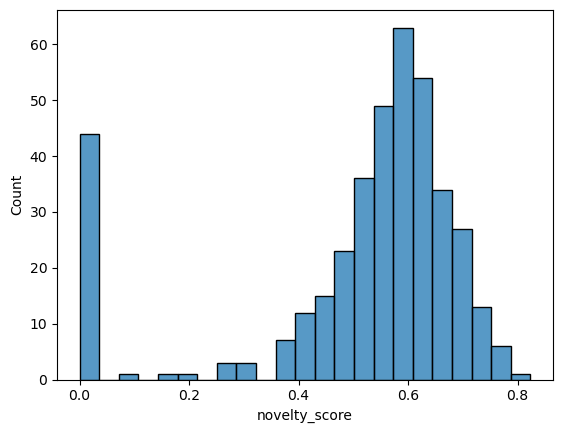

In [205]:
import seaborn as sns

sns.histplot(scaffolds_df['novelty_score'])

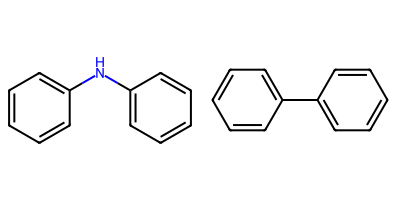

In [225]:
# draw pairs of scaffolds

from rdkit.Chem import Draw

i = 18

Draw.MolsToGridImage([scaffolds_df['scaffold_pred'][i], scaffolds_df['scaffold_train'][i]], molsPerRow=2)